In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from transformers import AutoTokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE, MDS
from sklearn.decomposition import PCA, LatentDirichletAllocation
import emoji
from tqdm import tqdm
from collections import defaultdict
from wordcloud import WordCloud, STOPWORDS

In [2]:
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", normalization=True, use_fast=False)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Function used to the index of the emojis in a set of tokens

In [2]:
df = pd.read_pickle("emoji_vectors_data.pkl")
df.head()

,tweet_id,embedding,emoji_id
0,748304287315468288,"[-0.47280642, 0.11537896, 0.27408963, 0.137825...",871
1,593564841647992832,"[-0.20254304, -0.1832999, -0.08655356, 0.12977...",871
2,1189693284391833600,"[-0.29617956, -0.16728494, 0.20603363, 0.20679...",871
3,660244596664893440,"[-0.1807276, -0.016389936, 0.11193222, 0.14420...",871
4,538844422410993664,"[0.36076596, -0.046867955, 0.16463731, 0.15527...",871


In [3]:
tweets = pd.read_csv("tweets_data.csv").dropna(subset=["tweet_id"])
tweets.head()

,author_id,created_at,geo,tweet_id,like_count,quote_count,reply_count,retweet_count,text
0,431948312,2017-01-30 23:55:49+00:00,,826217383039729664,0.0,0.0,0.0,0.0,We have the power👊💥😂💚 https://t.co/8en3JNwkny
1,418718492,2017-05-30 23:56:15+00:00,,869704038048202752,0.0,0.0,0.0,0.0,Sleep would be nice but Maiyahs cosies are bet...
2,340099697,2016-10-30 23:57:35+00:00,{'place_id': '31fd9d42c71e7afa'},792878143887605760,1.0,0.0,0.0,0.0,Lynn mad af cause Eric ate her chocolate chip ...
3,1249825087525728257,2020-10-30 23:59:39+00:00,,1322327339200630784,0.0,0.0,0.0,0.0,@KaileGedye text me cus I haven’t 🤣
4,205097885,2018-03-30 23:54:29+00:00,,979869505622069248,0.0,0.0,1.0,0.0,@juanlabia @Skelebird Yea but i feel like you ...


In [4]:
df.emoji_id.nunique()

47

There are 47 emojis to choose from

The emoji frequencies are vary greatly. Some are in the six figures while 

In [5]:
emoji_freq = df.emoji_id.value_counts()
emoji_freq.head(15)

88      402897
247     163274
280     114094
390     103253
933      28369
1658     27541
1422     21795
491      15105
6239     15096
722      12182
663      12180
1651      8728
1548      7127
1382      6668
1277      6661
Name: emoji_id, dtype: int64

Convert ids to emojis

In [7]:
ef_index = emoji_freq.index
ef_index = ef_index.map(tokenizer.convert_ids_to_tokens)
emoji_freq.set_axis(ef_index.map(emoji.EMOJI_UNICODE_ENGLISH)).head(15)

😂     402897
😭     163274
❤️    114094
😍     103253
🙏      28369
✨      27541
🤣      21795
😩      15105
🥺      15096
😘      12182
💕      12180
💀       8728
💖       7127
🔥       6668
🏽       6661
Name: emoji_id, dtype: int64

For our first example, let's start with the prayer hands emoji

In [8]:
prayer_hands_id = 933

prayer_hands_df = df.query("emoji_id == {}".format(prayer_hands_id)).drop("emoji_id", axis = 1)
prayer_hands_df

,tweet_id,embedding
0,649010168466796544,"[0.17880017, 0.05944991, 0.029669717, 0.362047..."
1,649010168466796544,"[0.31431267, 0.11376719, -0.017697126, 0.36743..."
2,649010168466796544,"[0.27834195, 0.033847056, 0.08875726, 0.325185..."
3,1233542243899731968,"[-0.5153002, -0.07138766, 0.07983874, -0.02516..."
4,1454598713612046336,"[-0.49861014, 0.15797623, 0.02909191, 0.323536..."
...,...,...
28364,693583914112159744,"[-0.17743944, 0.2504055, 0.19830742, 0.2940904..."
28365,550078795202699264,"[0.22381634, 0.17009586, -0.054807916, 0.36430..."
28366,550078795202699264,"[0.14281055, 0.17582378, -0.021657616, 0.57792..."
28367,550078795202699264,"[0.38438046, 0.34984455, -0.12370965, 0.483517..."


There are 28369 instances of the prayer hands emoji being used over the course of 8 years.

There are 21019 unique tweets that use the prayer hands emoji.

In [9]:
prayer_hands_df.tweet_id.nunique()

21019

A tiny sample of the tweets in this dataframe frequently use the prayer hands emojis

In [10]:
prayer_hands_df.tweet_id.value_counts()

615670335338233856     43
1046187630948429824    35
1079527433794137984    29
1012848168336179200    16
494633200657121280     15
                       ..
1277753287404593152     1
1012848084865486848     1
1454598945892618240     1
1322326937109409792     1
561312901492129792      1
Name: tweet_id, Length: 21019, dtype: int64

Let's see there are any temporal trends in the prayer hands emoji in this eight year time-span.

Connect the timestamp data from tweets by joining `tweets` with `prayer_hands_df`

In [11]:
prayer_hands_df = pd.merge(prayer_hands_df, tweets, on = "tweet_id")

In [108]:
# prayer_hands_df

In [14]:
tweet_rate = pd.Series(index=pd.to_datetime(prayer_hands_df.created_at)).sort_index()

/var/folders/lj/w4hy005d5vx9qy3lrwz0xdl80000gn/T/ipykernel_60742/2739952286.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  tweet_rate = pd.Series(index=pd.to_datetime(prayer_hands_df.created_at)).sort_index()


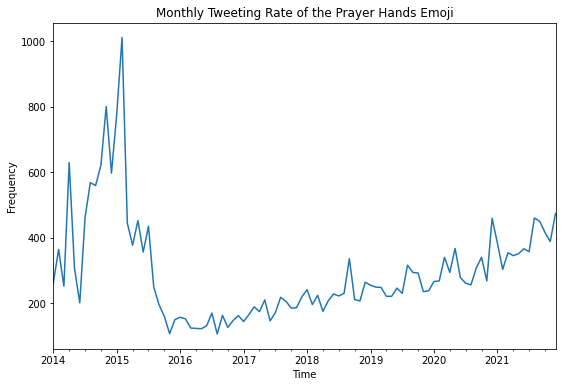

In [15]:
tweet_rate.resample("M").size().plot(figsize = (9,6))
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.title("Monthly Tweeting Rate of the Prayer Hands Emoji");

There was a big spike in 2015, followed by a crash in 2016, and since then it's been on a steady uprise.

Now let's move onto the clustering. But first we need to prepare the embeddings data.

In [16]:
prayer_embeddings = prayer_hands_df.embedding
prayer_embeddings.head()

0    [0.17880017, 0.05944991, 0.029669717, 0.362047...
1    [0.31431267, 0.11376719, -0.017697126, 0.36743...
2    [0.27834195, 0.033847056, 0.08875726, 0.325185...
3    [-0.5153002, -0.07138766, 0.07983874, -0.02516...
4    [-0.49861014, 0.15797623, 0.02909191, 0.323536...
Name: embedding, dtype: object

Transform the data so that it each value in the embedding array is organized under a single column

In [17]:
prayer_embeddings = prayer_embeddings.apply(pd.Series)
prayer_embeddings.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.178800,0.059450,0.029670,0.362048,-0.092572,-0.090097,0.056386,0.252641,0.187725,0.016247,...,0.187791,-0.361425,0.131782,0.127891,-0.284731,0.031908,0.065007,0.019091,-0.536011,0.011186
1,0.314313,0.113767,-0.017697,0.367432,-0.031179,-0.103953,0.092101,0.188067,0.316456,0.267391,...,0.087665,-0.313290,0.101829,0.229156,-0.241067,-0.055159,0.007168,-0.049920,-0.391997,0.050951
2,0.278342,0.033847,0.088757,0.325186,-0.001255,-0.589844,0.177111,0.269309,0.355679,0.166622,...,0.079534,-0.504104,-0.077147,0.052155,0.114016,0.118626,-0.132879,0.110086,-0.582188,-0.071241
3,-0.515300,-0.071388,0.079839,-0.025169,0.309406,-0.511755,0.300661,0.077642,0.342054,0.196609,...,0.272639,0.171139,-0.101986,0.448649,-0.298791,0.264860,-0.110508,-0.053058,-0.447471,-0.265488
4,-0.498610,0.157976,0.029092,0.323537,-0.170732,-0.101166,0.393581,0.203327,0.067146,-0.185658,...,0.379231,-0.281076,0.412709,-0.152941,0.028670,-0.278824,-0.020245,0.361500,-0.822515,0.226682


We begin with a simple KMeans with k = 3

In [18]:
%%time
km = KMeans(n_clusters=3, random_state=10)
km.fit(prayer_embeddings)

CPU times: user 32.2 s, sys: 7.27 s, total: 39.4 s
Wall time: 4.49 s


KMeans(n_clusters=3, random_state=10)

In [19]:
prayer_labels_k3 = km.labels_

Evaluate model using silhouette score

In [20]:
silhouette_score(prayer_embeddings, prayer_labels_k3)

0.12503745

0.125 is not a bad score but let's do bit of parameter tuning in order to find the best k value

In [21]:
sil_scores = []

k_range = range(2, 21)

for k in tqdm(k_range, total=19):
    km = KMeans(n_clusters=k, random_state=10)
    km.fit(prayer_embeddings)
    labels = km.labels_
    s_score = silhouette_score(prayer_embeddings, labels)
    sil_scores.append(s_score)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [09:15<00:00, 29.21s/it]


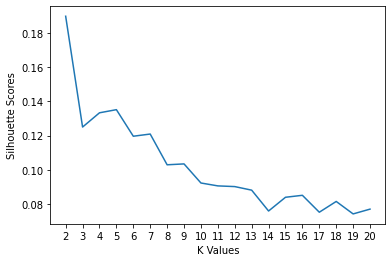

In [22]:
plt.plot(k_range, sil_scores)
plt.xlabel("K Values")
plt.ylabel("Silhouette Scores")
plt.xticks(ticks = k_range);

2 is obviously the best k value (this is typically the case), but 5 is worth examining as becuase it's a local maximum. 

In [23]:
km2 = KMeans(n_clusters=2, random_state=10)
km2.fit(prayer_embeddings)
labels_2 = km2.labels_


km5 = KMeans(n_clusters=5, random_state=10)
km5.fit(prayer_embeddings)
labels_5 = km5.labels_

Visualize the embeddings in a 2D scatter plot, color-encoding the dots with labels.

In [24]:
tsne = TSNE(random_state=10)
prayer_tsne = tsne.fit_transform(prayer_embeddings)

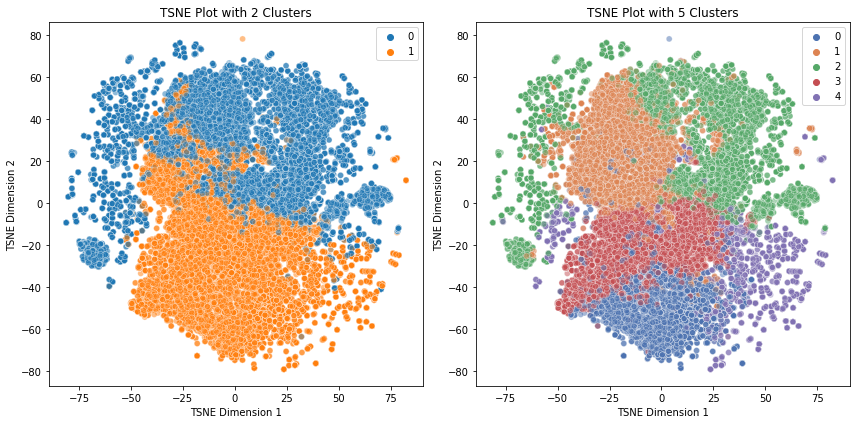

In [25]:
tsne1 = prayer_tsne[:, 0]
tsne2 = prayer_tsne[:, 1]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first scatter plot on the left subplot

sb.scatterplot(x = tsne1, y = tsne2, hue=labels_2,ax = axs[0], alpha = .5)
axs[0].set_title('TSNE Plot with 2 Clusters')

# Plot the second scatter plot on the right subplot
sb.scatterplot(x = tsne1, y = tsne2, hue=labels_5,ax = axs[1], alpha = .5, palette = "deep")
axs[1].set_title('TSNE Plot with 5 Clusters')


axs[0].set_xlabel('TSNE Dimension 1')
axs[0].set_ylabel('TSNE Dimension 2')
axs[1].set_xlabel('TSNE Dimension 1')
axs[1].set_ylabel('TSNE Dimension 2')
fig.tight_layout()

# Show the plot
plt.show()


This is a promising result, we can observe distinguishable clusters of the prayer_hands emoji's meaning

What are the distributions of the labels for each model

In [26]:
print(pd.value_counts(labels_2), "\n")
print(pd.value_counts(labels_2, normalize=True))

0    14509
1    13860
dtype: int64 

0    0.511439
1    0.488561
dtype: float64


In [27]:
print(pd.value_counts(labels_5), "\n")
print(pd.value_counts(labels_5, normalize=True))

2    9479
1    6377
3    5409
0    3864
4    3240
dtype: int64 

2    0.334132
1    0.224788
3    0.190666
0    0.136205
4    0.114209
dtype: float64


Now let's dive into what those clusters mean.

In [28]:
prayer_hands_df["labels2"] = labels_2
prayer_hands_df["labels5"] = labels_5

Remember that `prayer_hands_df` has duplicate tweets because each row represent one use of the prayer hands emoji and in some tweets there are multitple instances of that emoji.

Here I group by the `tweet_id` and apply the `value_counts` function to the cluster labels

In [29]:
labels2_df = prayer_hands_df.groupby("tweet_id").labels2.value_counts().unstack().fillna(0)
labels2_df.head()

labels2,0,1
tweet_id,,
429040710663168000,0.0,1.0
429040711967993856,1.0,0.0
429040712110186496,0.0,1.0
429040713247256576,1.0,0.0
429040714149007360,1.0,0.0


`labels2_df` shows the frequency of each cluster appearing in a tweet.

Repeat this process for 5 labels

In [30]:
labels5_df = prayer_hands_df.groupby("tweet_id").labels5.value_counts().unstack().fillna(0)
labels5_df.head()

labels5,0,1,2,3,4
tweet_id,,,,,
429040710663168000,0.0,0.0,0.0,1.0,0.0
429040711967993856,0.0,0.0,0.0,1.0,0.0
429040712110186496,0.0,0.0,0.0,1.0,0.0
429040713247256576,0.0,0.0,1.0,0.0,0.0
429040714149007360,0.0,1.0,0.0,0.0,0.0


Now I need to pull text belonging to a single cluster

In [31]:
cluster0_ids = labels2_df[labels2_df.iloc[:, 0] == 1].index
cluster0_text = tweets[tweets.tweet_id.isin(cluster0_ids)].text

Normalize the text using Bert-Tweet's function.

In [32]:
cluster0_text = cluster0_text.apply(tokenizer.normalizeTweet)

Find the most distinctive words in a cluster using tfidf

In [33]:
tf = TfidfVectorizer(min_df=50, max_df=.5, lowercase=False, stop_words='english')
tf.fit(cluster0_text)

TfidfVectorizer(lowercase=False, max_df=0.5, min_df=50, stop_words='english')

In [34]:
idf_scores = pd.Series(index=tf.get_feature_names(), data = tf.idf_)
idf_scores.nlargest(15)

DM                                 6.055246
Zayn                               6.055246
coming                             6.055246
grinning_face_with_smiling_eyes    6.055246
rest                               6.055246
rose                               6.055246
rt                                 6.055246
Oh                                 6.035828
One                                6.035828
comes                              6.035828
following                          6.035828
girls                              6.035828
look                               6.035828
BEST                               6.016780
For                                6.016780
dtype: float64

In [35]:
cluster1_ids = labels2_df[labels2_df.iloc[:, 1] == 1].index
cluster1_text = tweets[tweets.tweet_id.isin(cluster1_ids)].text

tf = TfidfVectorizer(min_df=50, max_df=.5, lowercase=False, stop_words='english')
tf.fit(cluster1_text)
idf_scores = pd.Series(index=tf.get_feature_names(), data = tf.idf_)
idf_scores.nlargest(15)

No                 6.184094
friend             6.184094
gonna              6.184094
world              6.184094
JaiBrooks1         6.164676
MostRequestLive    6.164676
guys               6.164676
THE                6.145628
Oh                 6.126936
baby               6.126936
KianLawley         6.108587
LIKED              6.108587
REVINED            6.108587
TO                 6.108587
wish               6.108587
dtype: float64

Apply topic modeling to the set of prayer hands texts.

In [36]:
prayer_text = prayer_hands_df.groupby("tweet_id").text.unique().apply(lambda x:x[0])
prayer_text.head()

tweet_id
429040710663168000                      Saturday please come sooner! 🙏💕
429040711967993856                              i just hope he okayy. 🙏
429040712110186496    Everything is falling into place💗 #steadyprogr...
429040713247256576              2 hr delay for now, praying for more 🙏👼
429040714149007360           New phone comes in tomorrow than godddd!🙏😍
Name: text, dtype: object

In [37]:
countvec = CountVectorizer(max_df=0.4, min_df=0.001,preprocessor=tokenizer.normalizeTweet, stop_words="english")
prayer_dtm = countvec.fit_transform(prayer_text).toarray()
features = countvec.get_feature_names()

In [38]:
prayer_lda = LatentDirichletAllocation(n_components=3, random_state=0)

In [39]:
prayer_topics = prayer_lda.fit_transform(prayer_dtm)

In [40]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic {}".format(topic_idx+1))
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
display_topics(prayer_lda, features, 10)

Topic 1
HTTPURL Thank God raising_hands You hope day good just The
Topic 2
follow eyes two_hearts smiling_face_with_heart loudly_crying_face ME love red_heart PLEASE HTTPURL
Topic 3
red_heart HTTPURL light_skin_tone medium face_with_tears_of_joy loudly_crying_face medium_skin_tone dark_skin_tone thumbs_up love


In [41]:
prayer_text = prayer_text.to_frame().assign(topic = prayer_topics.argmax(axis = 1))

Randomly pick out 5 tweets from each topic

In [42]:
for g in prayer_text.groupby("topic"):
    print("Topic {}:\n\n==>".format(g[0]+1),"\n==>".join(g[1].text.sample(5).tolist()), "\n", "=="*50,"\n")

Topic 1:

==> Good Night🙏💪Rio
==>@BlueDragonsFang @JosephNollaSJ @ooohglobbits @Matt_Dillahunty @Aron_Ra SORRY!...I don't Engage with Atheists...We operate on Different Frequencies...You operate on the Earthly Bandwidth, We Spiritual People operate on a Higher Frequency Supernatural Band...Sorry, We wouldn't be able to Communicate! 🙄🙏💒👍 https://t.co/APQWJJvUxL
==>Absolute respect 🙌 👏 🙏 https://t.co/oAxC9AVXTO
==>@SchatzJL @BernieSanders I love that, thank you!🙏 If he gets 5 million individual donations, it will be the fastest a campaign has reached that goal in US history. Since he's running a grassroots campaign (no bilionaire donors/fundraisers), it's a huge achievement &amp; sends a message to the establishment!
==>God's grace 🙏 

Topic 2:

==> Please... Daniel pls follow me 😘😘 @971AMPRadio #PlayWhatAmI 👋🙏 
@SeaveyDaniel https://t.co/iYfrEPdDib
==>@ArianaGrande follow me please 🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏
==>☀️ Hiii @Calum5SOS 🙋 ☀️

🙏U can try to follow me, Cal? 🙏

☀️ I

Compare the topics with the cluster labels

In [43]:
labels2_df = labels2_df.join(prayer_text.topic)
labels2_df

,0,1,topic
tweet_id,,,
429040710663168000,0.0,1.0,0
429040711967993856,1.0,0.0,0
429040712110186496,0.0,1.0,0
429040713247256576,1.0,0.0,2
429040714149007360,1.0,0.0,0
...,...,...,...
1476704644822831104,1.0,0.0,2
1476704645741518848,0.0,1.0,2
1476704646056062976,0.0,1.0,0


In [44]:
labels2_df[labels2_df.iloc[:, 0]==1].topic.value_counts(normalize=True).sort_index()

0    0.482746
1    0.271443
2    0.245811
Name: topic, dtype: float64

In [45]:
labels2_df[labels2_df.iloc[:, 1]==1].topic.value_counts(normalize=True).sort_index()

0    0.471422
1    0.171796
2    0.356782
Name: topic, dtype: float64

Temporal Analysis

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28369 entries, 0 to 28368
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_id    28369 non-null  int64 
 1   created_at  28369 non-null  object
dtypes: int64(1), object(1)
memory usage: 664.9+ KB


In [51]:
prayer_hands_time = prayer_hands_df[["tweet_id","created_at"]].set_index("tweet_id")

In [52]:
labels2_df = labels2_df.join(prayer_hands_time)

In [53]:
labels2_df["created_at"] = pd.to_datetime(labels2_df.created_at)

In [54]:
labels2_tweetrate = labels2_df.set_index("created_at").loc[:, [0,1]]
labels2_tweetrate.head()

,0,1
created_at,,
2014-01-30 23:57:31+00:00,0.0,1.0
2014-01-30 23:57:31+00:00,1.0,0.0
2014-01-30 23:57:31+00:00,0.0,1.0
2014-01-30 23:57:31+00:00,1.0,0.0
2014-01-30 23:57:32+00:00,1.0,0.0


(0.0, 1.0)

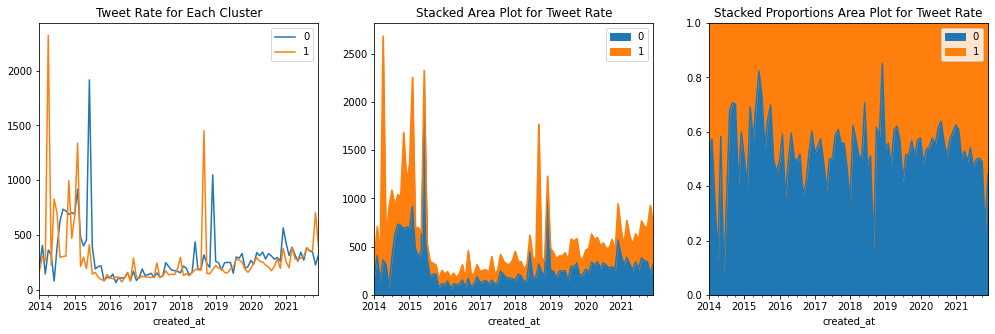

In [56]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(17, 5))

monthly_rate = labels2_tweetrate.resample("M").sum()
monthly_rate.plot(ax = axes[0])

axes[0].set_title('Tweet Rate for Each Cluster')

monthly_rate.plot(kind = "area", ax = axes[1])

axes[1].set_title('Stacked Area Plot for Tweet Rate')

monthly_rate.divide(monthly_rate.sum(axis = 1),axis = 0).plot(kind = "area", ax = axes[2])

axes[2].set_title('Stacked Proportions Area Plot for Tweet Rate')
axes[2].set_ylim(0, 1)
# plt.xlabel("Time")
# plt.ylabel("Frequency")
# plt.title("Monthly Tweeting Rate of the Prayer Hands Emoji");

Repeat Process for 5 labels

In [57]:
labels5_df = labels5_df.join(prayer_text.topic)
labels5_df.head()

,0,1,2,3,4,topic
tweet_id,,,,,,
429040710663168000,0.0,0.0,0.0,1.0,0.0,0
429040711967993856,0.0,0.0,0.0,1.0,0.0,0
429040712110186496,0.0,0.0,0.0,1.0,0.0,0
429040713247256576,0.0,0.0,1.0,0.0,0.0,2
429040714149007360,0.0,1.0,0.0,0.0,0.0,0


In [58]:
for i in range(5):
    topic_props = labels5_df[labels5_df.iloc[:, i]==1].topic.value_counts(normalize=True).sort_index()
    print("Topic {}:\n{}".format(i, topic_props), "\n")

Topic 0:
0    0.314946
1    0.205367
2    0.479687
Name: topic, dtype: float64 

Topic 1:
0    0.636569
1    0.097065
2    0.266366
Name: topic, dtype: float64 

Topic 2:
0    0.390064
1    0.367898
2    0.242038
Name: topic, dtype: float64 

Topic 3:
0    0.523598
1    0.100777
2    0.375625
Name: topic, dtype: float64 

Topic 4:
0    0.107266
1    0.770761
2    0.121972
Name: topic, dtype: float64 



In [59]:
labels5_df = labels5_df.join(prayer_hands_time)
labels5_tweetrate = labels5_df.set_index("created_at").loc[:, [0,1,2,3,4]]
labels5_tweetrate.head()

,0,1,2,3,4
created_at,,,,,
2014-01-30 23:57:31+00:00,0.0,0.0,0.0,1.0,0.0
2014-01-30 23:57:31+00:00,0.0,0.0,0.0,1.0,0.0
2014-01-30 23:57:31+00:00,0.0,0.0,0.0,1.0,0.0
2014-01-30 23:57:31+00:00,0.0,0.0,1.0,0.0,0.0
2014-01-30 23:57:32+00:00,0.0,1.0,0.0,0.0,0.0


In [60]:
labels5_tweetrate.index = pd.to_datetime(labels5_tweetrate.index)

Text(0.5, 1.0, 'Stacked Proportions Area Plot for Tweet Rate')

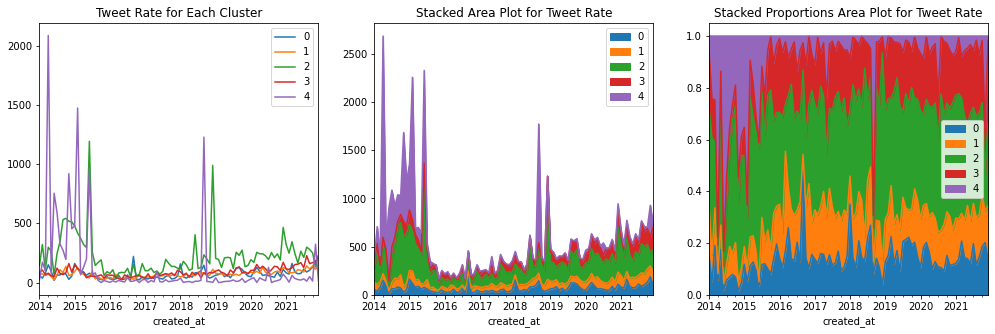

In [61]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(17, 5))

monthly_rate = labels5_tweetrate.resample("M").sum()
monthly_rate.plot(ax = axes[0])

axes[0].set_title('Tweet Rate for Each Cluster')

monthly_rate.plot(kind = "area", ax = axes[1])

axes[1].set_title('Stacked Area Plot for Tweet Rate')

monthly_rate.divide(monthly_rate.sum(axis = 1),axis = 0).plot(kind = "area", ax = axes[2])

axes[2].set_title('Stacked Proportions Area Plot for Tweet Rate')

In [68]:
a = {"0": "arts_&_culture",
"1": "business_&_entrepreneurs",
"2": "celebrity_&_pop_culture",
    "3": "diaries_&_daily_life",
    "4": "family",
    "5": "fashion_&_style",
    "6": "film_tv_&_video",
    "7": "fitness_&_health",
    "8": "food_&_dining",
    "9": "gaming",
    "10": "learning_&_educational",
    "11": "music",
    "12": "news_&_social_concern",
    "13": "other_hobbies",
    "14": "relationships",
    "15": "science_&_technology",
    "16": "sports",
    "17": "travel_&_adventure",
    "18": "youth_&_student_life"}
for i in list(a.values()):
    print(i.replace("&", "and")+", ")

arts_and_culture, 
business_and_entrepreneurs, 
celebrity_and_pop_culture, 
diaries_and_daily_life, 
family, 
fashion_and_style, 
film_tv_and_video, 
fitness_and_health, 
food_and_dining, 
gaming, 
learning_and_educational, 
music, 
news_and_social_concern, 
other_hobbies, 
relationships, 
science_and_technology, 
sports, 
travel_and_adventure, 
youth_and_student_life, 


I applied this [topic model](https://huggingface.co/cardiffnlp/tweet-topic-21-multi) that identifies multiple topics in tweets to my entire twitter dataset.

It outputs scores for 19 of the following topics:

arts_and_culture, 
business_and_entrepreneurs, 
celebrity_and_pop_culture, 
diaries_and_daily_life, 
family, 
fashion_and_style, 
film_tv_and_video, 
fitness_and_health, 
food_and_dining, 
gaming, 
learning_and_educational, 
music, 
news_and_social_concern, 
other_hobbies, 
relationships, 
science_and_technology, 
sports, 
travel_and_adventure, 
youth_and_student_life, 

In [70]:
topic_scores = pd.read_pickle("topic_scores_df.pkl")
topic_scores.head()

,arts_&_culture,business_&_entrepreneurs,celebrity_&_pop_culture,diaries_&_daily_life,family,fashion_&_style,film_tv_&_video,fitness_&_health,food_&_dining,gaming,learning_&_educational,music,news_&_social_concern,other_hobbies,relationships,science_&_technology,sports,travel_&_adventure,youth_&_student_life
tweet_id,,,,,,,,,,,,,,,,,,,
826217383039729664,0.016335,0.002809,0.042542,0.041006,0.001388,0.000822,0.026560,0.001293,0.000906,0.001990,0.002153,0.018368,0.900727,0.037248,0.002019,0.001480,0.008375,0.001214,0.000729
869704038048202752,0.033339,0.020019,0.008277,0.928427,0.036049,0.008726,0.022503,0.005397,0.022037,0.018738,0.007847,0.010280,0.007789,0.139367,0.183162,0.013123,0.015434,0.057417,0.005741
792878143887605760,0.049794,0.024329,0.016242,0.800291,0.354433,0.007569,0.019055,0.011927,0.894959,0.018831,0.016835,0.018176,0.031969,0.050481,0.134443,0.016929,0.037986,0.043149,0.021827
1322327339200630784,0.008946,0.006743,0.073223,0.878838,0.021650,0.005687,0.008047,0.003915,0.007562,0.004917,0.005669,0.026181,0.013558,0.093159,0.199417,0.003914,0.038573,0.007115,0.008394
979869505622069248,0.040473,0.068227,0.210160,0.151031,0.012991,0.923727,0.075072,0.019732,0.007009,0.017731,0.013973,0.015932,0.028739,0.053301,0.028329,0.010131,0.036371,0.020247,0.013523


Let's see how the clusters differ based on their topics scores for the two labels model

In [94]:
mean_topic_scores_lab0 = topic_scores.loc[labels2_df[labels2_df.iloc[:, 0] == 1].index].mean()
mean_topic_scores_lab1 = topic_scores.loc[labels2_df[labels2_df.iloc[:, 1] == 1].index].mean()

mean_topic_scores = pd.concat([mean_topic_scores_lab0, 
                               mean_topic_scores_lab1], axis = 1).rename(columns = {0:"cluster1",
                                                                                   1:"cluster2"})

In [96]:
mean_topic_scores.assign(diff = abs(mean_topic_scores.loc[:, "cluster1"] - mean_topic_scores.loc[:, 'cluster2'])).sort_values("diff", 
                                                                                                            ascending = False)

,cluster1,cluster2,diff
celebrity_&_pop_culture,0.340971,0.227770,0.113201
relationships,0.196792,0.102878,0.093914
music,0.192541,0.141671,0.050870
family,0.082195,0.040271,0.041924
diaries_&_daily_life,0.409579,0.370966,0.038612
other_hobbies,0.131310,0.169547,0.038237
film_tv_&_video,0.097052,0.069998,0.027055
sports,0.053038,0.073818,0.020780
fitness_&_health,0.024074,0.013724,0.010351
youth_&_student_life,0.018075,0.010105,0.007970


In [97]:
mean_topic_scores = topic_scores.loc[labels5_df[labels5_df.loc[:, 0] == 1].index].mean().to_frame()

for i in range(1, 5):
    mean_topic_scores_lab = topic_scores.loc[labels5_df[labels5_df.loc[:, i] == 1].index].mean().to_frame()
    mean_topic_scores = pd.concat([mean_topic_scores, mean_topic_scores_lab], axis = 1)
    
mean_topic_scores.columns = ["cluster{}".format(i) for i in range(1, 6)]

In [98]:
mean_topic_scores.assign(topic_var = mean_topic_scores.std(axis = 1)).sort_values("topic_var", ascending = False)

,cluster1,cluster2,cluster3,cluster4,cluster5,topic_var
celebrity_&_pop_culture,0.245686,0.188355,0.417135,0.159351,0.669669,0.211588
music,0.165602,0.130651,0.233061,0.089123,0.326667,0.093302
diaries_&_daily_life,0.334800,0.426639,0.410463,0.402976,0.227029,0.082386
relationships,0.102313,0.142805,0.232696,0.083725,0.194091,0.062238
news_&_social_concern,0.186652,0.216579,0.154105,0.185156,0.097683,0.045110
film_tv_&_video,0.078469,0.074194,0.085939,0.042636,0.163419,0.044798
other_hobbies,0.169062,0.131984,0.133603,0.213627,0.104443,0.042069
family,0.040368,0.071445,0.086844,0.040813,0.034403,0.023042
sports,0.067033,0.081845,0.042124,0.070847,0.025905,0.022893
arts_&_culture,0.094196,0.080597,0.081589,0.102813,0.052682,0.018993


I used pysentimiento to generate emotion scores for the tweets

In [102]:
emotion_scores = pd.read_csv("tweet_emotions.csv", index_col=[0])
emotion_scores.head()

,others,joy,sadness,anger,surprise,disgust,fear
tweet_id,,,,,,,
826217383039729664,0.120837,0.870141,0.001321,0.002533,0.002166,0.001234,0.001768
869704038048202752,0.966302,0.014712,0.004544,0.001032,0.004794,0.004922,0.003694
792878143887605760,0.955326,0.031291,0.001884,0.001713,0.005112,0.001853,0.002820
1322327339200630784,0.967165,0.015512,0.002577,0.001353,0.004344,0.003581,0.005467
979869505622069248,0.853755,0.136055,0.002361,0.001260,0.003110,0.001806,0.001653


Let's see how the topics differ by emotion scores

In [103]:
mean_emotion_scores_lab0 = emotion_scores.loc[labels2_df[labels2_df.iloc[:, 0] == 1].index].mean()
mean_emotion_scores_lab1 = emotion_scores.loc[labels2_df[labels2_df.iloc[:, 1] == 1].index].mean()

mean_emotion_scores = pd.concat([mean_emotion_scores_lab0, 
                               mean_emotion_scores_lab1], axis = 1).rename(columns = {0:"cluster1",
                                                                                   1:"cluster2"})
mean_emotion_scores.assign(diff = abs(mean_emotion_scores.loc[:, "cluster1"] - mean_emotion_scores.loc[:, 'cluster2'])).sort_values("diff", 
                                                                                                            ascending = False)

,cluster1,cluster2,diff
others,0.423238,0.496974,0.073736
joy,0.396595,0.352179,0.044415
sadness,0.143876,0.113130,0.030747
fear,0.012116,0.006826,0.005289
surprise,0.005478,0.009570,0.004093
disgust,0.013242,0.014964,0.001722
anger,0.005456,0.006356,0.000899


In [104]:
mean_emotion_scores = emotion_scores.loc[labels5_df[labels5_df.loc[:, 0] == 1].index].mean().to_frame()

for i in range(1, 5):
    mean_emotion_scores_lab = emotion_scores.loc[labels5_df[labels5_df.loc[:, i] == 1].index].mean().to_frame()
    mean_emotion_scores = pd.concat([mean_emotion_scores, mean_emotion_scores_lab], axis = 1)
    
mean_emotion_scores.columns = ["cluster{}".format(i) for i in range(1, 6)]

In [106]:
mean_emotion_scores.assign(emotion_var = mean_emotion_scores.std(axis = 1)).sort_values("emotion_var", ascending = False)

,cluster1,cluster2,cluster3,cluster4,cluster5,emotion_var
others,0.490365,0.440690,0.405872,0.470474,0.643694,0.091531
joy,0.375975,0.370457,0.417484,0.343453,0.272487,0.053666
sadness,0.101768,0.124144,0.152957,0.163571,0.064283,0.040092
disgust,0.009888,0.026914,0.007561,0.006967,0.005652,0.008809
fear,0.005318,0.015553,0.008329,0.006028,0.006420,0.004189
surprise,0.009771,0.011656,0.004096,0.006640,0.003297,0.003591
anger,0.006914,0.010586,0.003702,0.002867,0.004167,0.003150
